Classification Task <br>
Input: text data <br>
Output: Copom's decision (keep, raise, lower) interest rate

In [1]:
import pandas as pd 
import re 
import os
import nltk
import numpy as np
import spacy
import eli5
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm, tree, neural_network, neighbors, ensemble
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

In [2]:
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
plt.rcParams["figure.figsize"] = (60,30)
plt.rcParams['figure.dpi'] = 90
plt.rcParams.update({'font.size': 50})

In [3]:
AtasFolder = "../atas"
listAtas = os.listdir(AtasFolder)
corpus = []
meeting = []
for ata in listAtas:
    meeting.append(int(re.search("[0-9]+",ata).group()))
    with open(AtasFolder + "/" + ata,'rt', encoding='utf-8') as f:
        lines = f.readlines()
        if lines: 
            lines = ' '.join(lines)
            corpus.append(lines)

print(len(corpus),"atas")
dfCorpus = pd.DataFrame(corpus, index = meeting, columns=["corpus"])
del corpus, meeting

228 atas


In [4]:
decisions = pd.read_csv("../decisions.csv")
decisions.index = np.int64(decisions.meeting.values)
decisions = decisions["decision"]
decisions = decisions.to_frame(name="decisions")
decisions.value_counts()

decisions
lower        89
keep         84
raise        63
dtype: int64

In [5]:
dfCorpus = dfCorpus.join(decisions)
del decisions

# Cleaning data

In [6]:
Mystopwords = ['acordar','agora','ainda','aladi','alegrar','além','antar','ante','anthero','antonio','apenas','apesar','apresentação','aquém','araújo','cada','capitar','carioca','carteiro','contra','corpus','corrêa','costa','daquela','demais','diante','edson','entanto','estar','estevar','então','feltrim','final','finar','geral','içar','ie','intuito'] + \
['le','luiz','luzir','mediante','meirelles','mercar','moraes','necessariamente','neto','of','oficiar','oliveira','onde','ora','parir','paulo','pelar','pesar','pilar','pois','primo','quadrar','reinar','res','resinar','reunião','ser','sob','sobre','somente','sr','tal','tais','tanto','thomson','tipo','todo','tony','usecheque','vasconcelos'] + \
['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z'] + \
['um','dois','três','quatro','cinco','seis','sete','oito','nove','dez','onze','doze','treze','catorze','quinze','dezesseis','dezessete','dezoito','dezenove','vinte'] + \
['aquela','aquelas','aquele','aqueles','àquela','àquelas','daquele','daqueles','daquela','daquelas','naquele','naqueles','naquela','naquelas','neste','nesta','nestes','nestas','nisto','nesse','nessa','nesses','nessas','nisso'] + \
['janeiro','fevereiro','março','abril','maio','junho','julho','agosto','setembro','outubro','novembro','dezembro','mês','meses','ano','anos'] + [str(i) for i in range(10)] + nltk.corpus.stopwords.words('portuguese')

print("Number of stopwords: ",len(Mystopwords))

Number of stopwords:  378


In [7]:
corpus = dfCorpus.corpus.to_list()
for i in range(len(corpus)):
    corpus[i]= corpus[i].lower()
    corpus[i] = re.sub('\n', ' ', corpus[i]) # remove newline
    corpus[i] = re.sub('[0-9]+', ' ', corpus[i]) #remove numbers
    corpus[i] = re.sub(r'[^\w\s]',' ',corpus[i]) #remove punctuation
    corpus[i] = re.sub('º','',corpus[i])
    corpus[i] = re.sub('ª','',corpus[i])
    corpus[i] = re.sub('@','',corpus[i])
    corpus[i] = re.sub('#','',corpus[i])


## lemmatization

In [8]:
#large portuguese model
nlp = spacy.load('pt_core_news_lg', disable=['parser', 'ner'])

for i in range(len(corpus)): 
    doc = nlp(corpus[i]) 
    corpus[i]=" ".join([token.lemma_ for token in doc]) 

# fix wrong lemmas
for i in range(len(corpus)):
    corpus[i] = re.sub("atar","ata", corpus[i])
    corpus[i] = re.sub("agregar","agregado", corpus[i])
    corpus[i] = re.sub("atuais","atual", corpus[i])
    corpus[i] = re.sub("barreirar","barreira", corpus[i])
    corpus[i] = re.sub("bolhar","bolha", corpus[i])
    corpus[i] = re.sub("comerciar","comércio", corpus[i])
    corpus[i] = re.sub("comer","como", corpus[i])
    corpus[i] = re.sub("conjuntar","conjunto", corpus[i])
    corpus[i] = re.sub("cifrar","cifra", corpus[i])
    corpus[i] = re.sub("curvar","curva", corpus[i])
    corpus[i] = re.sub("demandar","demanda", corpus[i])
    corpus[i] = re.sub("desalentar","desalento", corpus[i])
    corpus[i] = re.sub("marginar","marginal", corpus[i])
    corpus[i] = re.sub("mediano","mediana", corpus[i])
    corpus[i] = re.sub("mear","meio", corpus[i])
    corpus[i] = re.sub("mercar","mercado", corpus[i])
    corpus[i] = re.sub("meter","meta", corpus[i])
    corpus[i] = re.sub("ofertar","oferta", corpus[i])
    corpus[i] = re.sub("oitavar","oitavo", corpus[i])
    corpus[i] = re.sub("orar","ora", corpus[i])
    corpus[i] = re.sub("parir","para", corpus[i])
    corpus[i] = re.sub("picar","pico", corpus[i])
    corpus[i] = re.sub("queda","quedo", corpus[i])
    corpus[i] = re.sub("redar","rede", corpus[i])
    corpus[i] = re.sub("resultar","resultado", corpus[i])
    corpus[i] = re.sub("riscar","risco", corpus[i])
    corpus[i] = re.sub("segundar","segundo", corpus[i])
    corpus[i] = re.sub("trazido","trazer", corpus[i])
    corpus[i] = re.sub("votar","voto", corpus[i])
    
dfCorpus["clean_corpus"] = corpus
del corpus, doc, i, nlp

# Train, Test Split

In [9]:
# Dataset preparation

# Divisão dos textos em um conjunto de treinamento e outro de validação
X_train, X_test, y_train, y_test = model_selection.train_test_split(dfCorpus.clean_corpus.to_list(), dfCorpus.decisions.to_list(), 
                                                                      test_size=0.30, 
                                                                      random_state = 100, 
                                                                      stratify=dfCorpus.decisions.to_list() )
print("Train:",len(X_train),len(y_train))
print("Test:",len(X_test),len(y_test))

Train: 160 160
Test: 69 69


# Encoder labels

In [10]:
# Copy labels
y_train_labels = y_train.copy()
y_test_labels = y_test.copy()

#Tratamento dos dados de saída
# Codificação das variveis alvo da classificação
encoder = preprocessing.LabelEncoder() #criação do codificador
encoder.fit(dfCorpus.decisions)
y_train = encoder.transform(y_train) #codificação dos dados de treinamento
y_test = encoder.transform(y_test) #codificação dos dados de validação
labels = encoder.classes_ #criação de uma lista contendo os tipos de norma (classes da classificação)
print(labels)

['keep' 'lower' 'raise']


# tf-idf vectorizer

In [11]:
max_tokens = 2000
#DTM-TF-IDF
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}',
                             stop_words=Mystopwords,
                             max_df = 0.8,
                             min_df = 0.1,
                             #ngram_range=(1, 2), 
                             max_features = max_tokens)
tfidf_vect.fit(X_train) 

print("tfidf:",len(tfidf_vect.get_feature_names_out())," tokens")

X_train_tfidf =  tfidf_vect.transform(X_train)
X_test_tfidf =  tfidf_vect.transform(X_test)
list_words = list(tfidf_vect.vocabulary_.keys())

tfidf: 1594  tokens


# Auxiliary functions

In [12]:
def train_model(classifier, train_x, train_y, test_x, test_y, parameters = None):
    """
    #classifier: sklearn classifier model
    #train_x: train data input (X)
    #train_y: train data output (Y)
    #test_x: test data input (X)
    #test_y: test data output(Y)
    #parameters: classifier's parameters for GridSearch
    
    """
    
        
    if (__name__ == "__main__") & (parameters != None) :
        # multiprocessing requires the fork to happen in a __main__ protected
        # block

        # find the best parameters for both the feature extraction and the
        # classifier
        grid_search = GridSearchCV(classifier, parameters, n_jobs=-1, verbose=0,cv=5)
        grid_search.fit(train_x, train_y)
        best_parameters = grid_search.best_estimator_.get_params()
        for param_name in sorted(parameters.keys()):
            print("\t%s: %r" % (param_name, best_parameters[param_name]))
        predictions= grid_search.best_estimator_.predict(test_x)
        classifier = grid_search.best_estimator_
        
    else:
        # train the classifier
        classifier.fit(train_x, train_y)
        # make predictions
        predictions = classifier.predict(test_x)
    

    #calcula a matriz de confusão
    confusionMatrix(predictions, test_y)
    print("\n") #pula uma linha
    #cria um relatório com base nas previsões realizdas
    classificationReport(predictions, test_y)
    
    #calcula o kapppa
    kappa = metrics.cohen_kappa_score(test_y, predictions)
    print("Kappa score: {:.3f}\n".format(kappa))
    acc = metrics.accuracy_score(test_y, predictions)
    print("Accuracy score: {:.3f}\n".format(acc))
    f1 = metrics.f1_score(test_y, predictions, average='weighted')
    print("f1 weighted score: {:.3f}\n".format(f1))
    acc_bal = metrics.balanced_accuracy_score(test_y, predictions)
    print("Balanced Accuracy score: {:.3f}\n".format(acc_bal))
    
    # retorna a acurácia do modelo        
    return  classifier

def confusionMatrix(predictions, real):
    X = np.array( metrics.confusion_matrix(y_true=real,y_pred=predictions))
    X = pd.DataFrame(X,index = labels, columns = labels)
    print(X)
    return


def classificationReport(predictions, real):
    print(metrics.classification_report(y_true=real,y_pred=predictions, target_names=labels))    
    return


# Decision Tree

In [13]:
#DECISION TREE
nome = "DECISION TREE"
DecisionTreeModel = tree.DecisionTreeClassifier()
parameters_ = {'criterion': ('gini', 'entropy'),
               'splitter':('best','random'),
               'max_depth':(10, 20, 40, 50, None),
               'class_weight' : ('balanced',None)
               }

# TF IDF Vectors
print ("\n",nome," - TF-IDF VECTORS")
DecisionTreeModel = train_model(DecisionTreeModel, X_train_tfidf, y_train, X_test_tfidf, y_test, parameters = parameters_)



 DECISION TREE  - TF-IDF VECTORS
	class_weight: None
	criterion: 'entropy'
	max_depth: 40
	splitter: 'random'
       keep  lower  raise
keep     12      7      6
lower     3     20      2
raise     6      5      8


              precision    recall  f1-score   support

        keep       0.57      0.48      0.52        25
       lower       0.62      0.80      0.70        25
       raise       0.50      0.42      0.46        19

    accuracy                           0.58        69
   macro avg       0.57      0.57      0.56        69
weighted avg       0.57      0.58      0.57        69

Kappa score: 0.361

Accuracy score: 0.580

f1 weighted score: 0.569

Balanced Accuracy score: 0.567



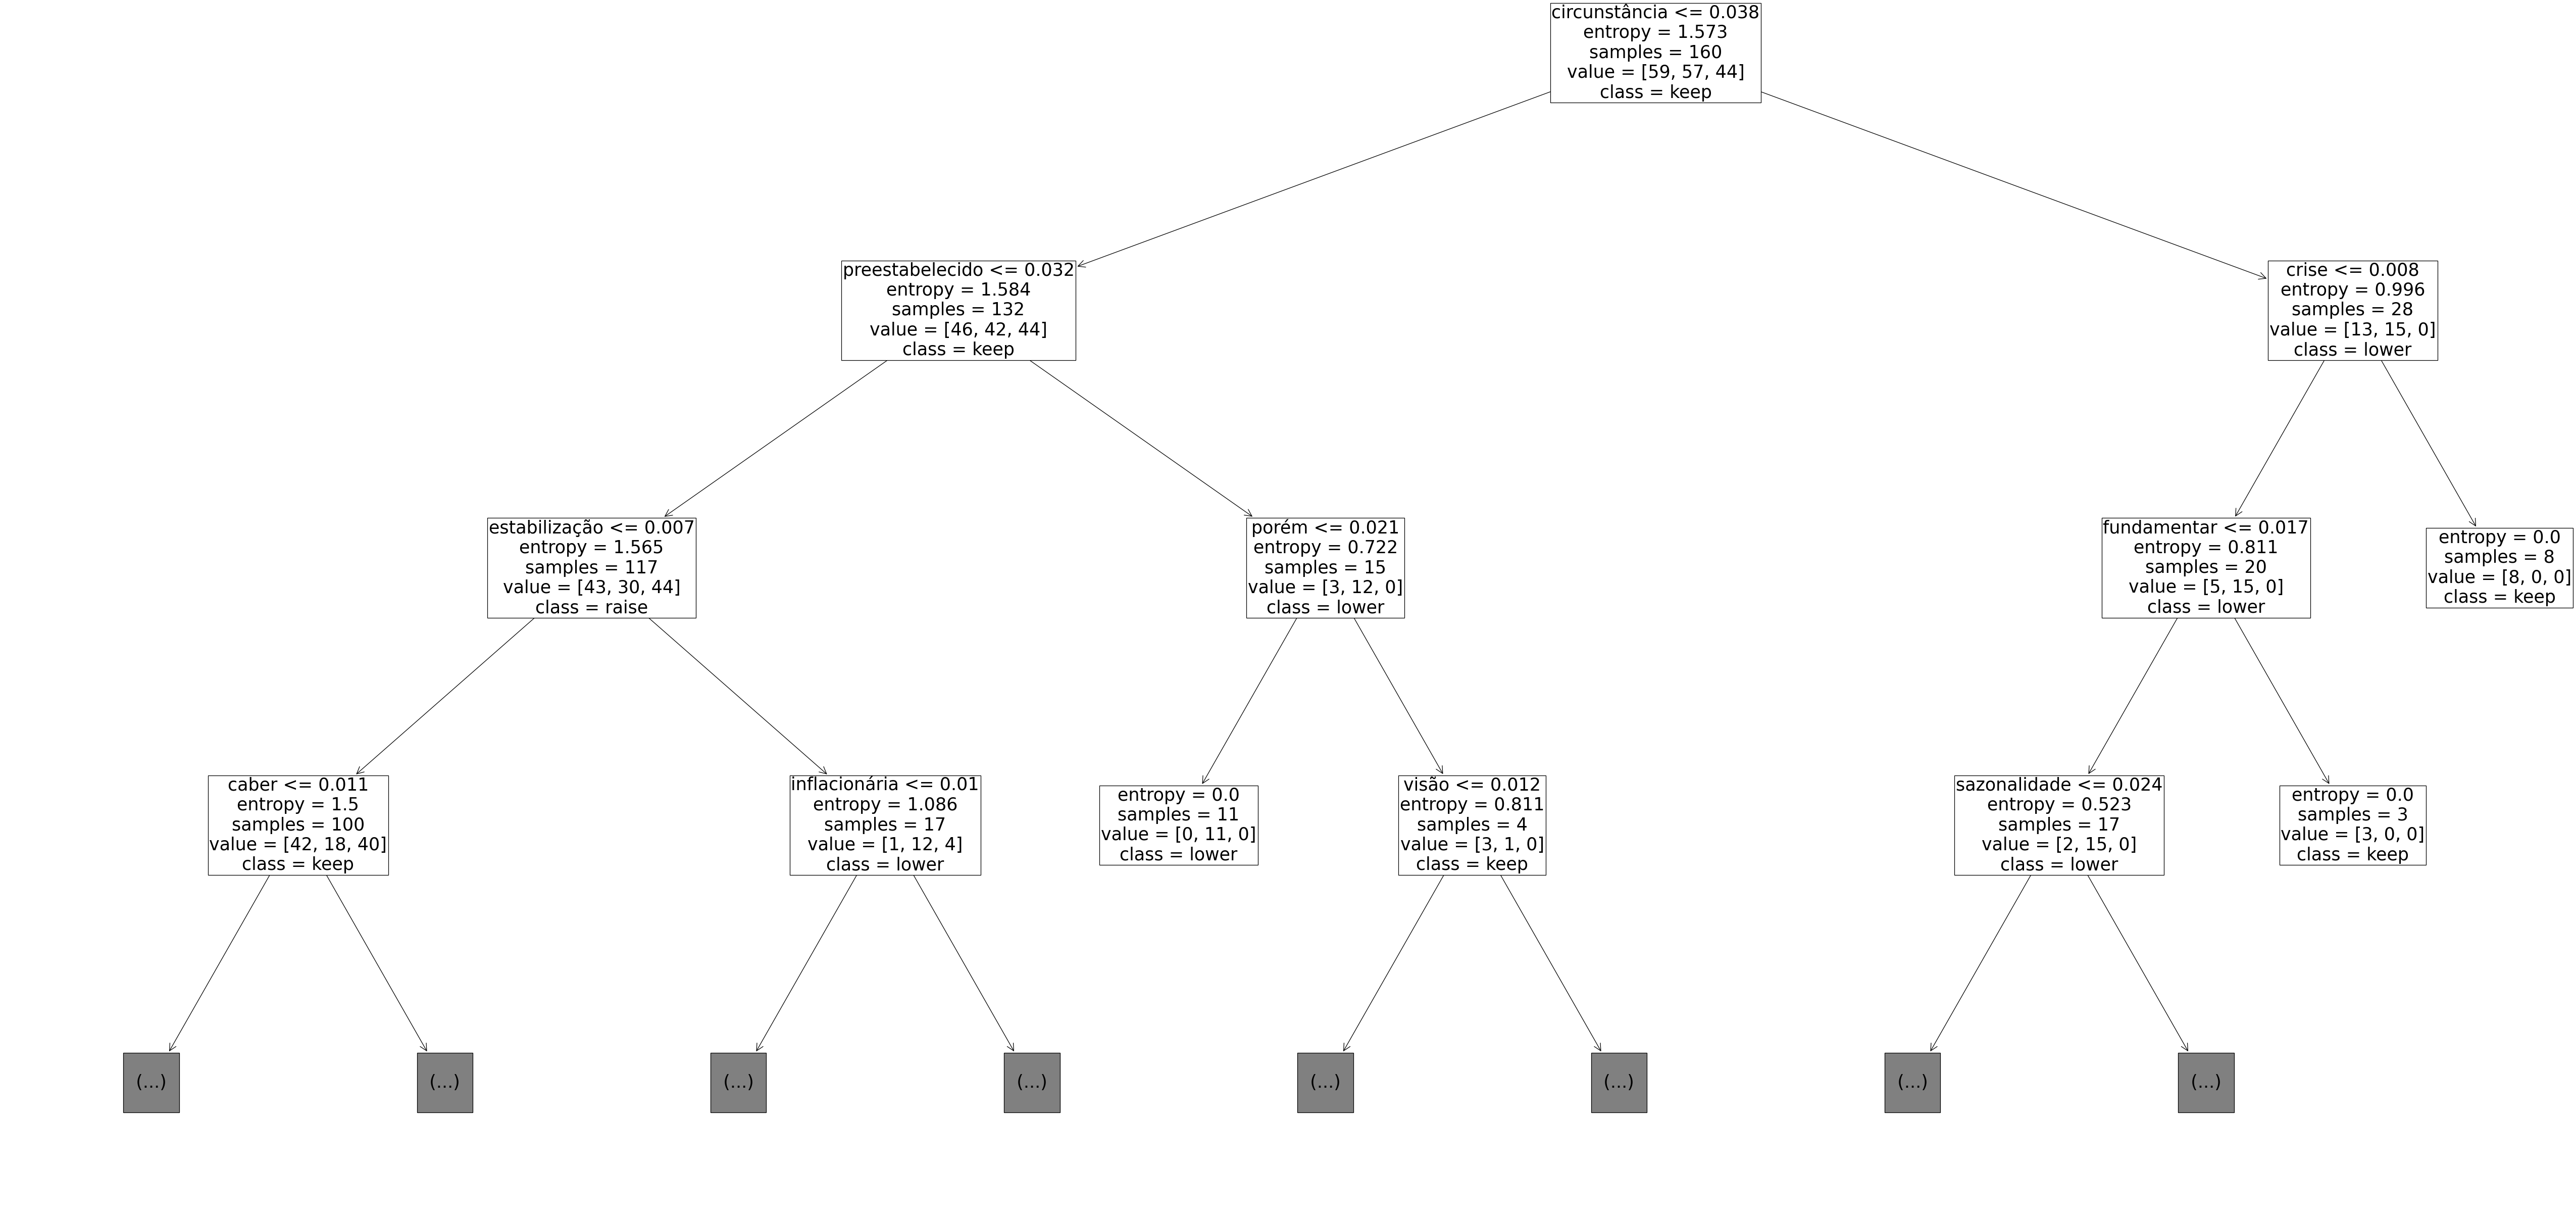

In [14]:
tree.plot_tree(DecisionTreeModel, max_depth=3, feature_names=list_words, class_names=labels);

In [15]:
eli5.show_weights(DecisionTreeModel, top=10, target_names=labels, feature_names=list_words)

Weight,Feature
0.0603,preestabelecido
0.0590,inflacionária
0.0590,caber
0.0586,circunstância
0.0582,estabilização
0.0493,fabril
0.0464,crise
0.0462,incorpora
0.0442,prognóstico
0.0420,aproximadamente


# Logistic Regression

In [16]:
#LOGISTIC REGRESSION
nome = "Logistic Regression"
LogisticRegressionModel = linear_model.LogisticRegression()
parameters_ = {'C':(0.5, 1.0),
               'class_weight' : ('balanced',None)}

# TF IDF Vectors
print ("\n",nome," - TF-IDF VECTORS")
LogisticRegressionModel = train_model(LogisticRegressionModel, X_train_tfidf, y_train, X_test_tfidf, y_test, parameters = parameters_)



 Logistic Regression  - TF-IDF VECTORS
	C: 1.0
	class_weight: None
       keep  lower  raise
keep     13     10      2
lower     7     15      3
raise     7      1     11


              precision    recall  f1-score   support

        keep       0.48      0.52      0.50        25
       lower       0.58      0.60      0.59        25
       raise       0.69      0.58      0.63        19

    accuracy                           0.57        69
   macro avg       0.58      0.57      0.57        69
weighted avg       0.57      0.57      0.57        69

Kappa score: 0.339

Accuracy score: 0.565

f1 weighted score: 0.567

Balanced Accuracy score: 0.566



In [17]:
coefLogReg = pd.DataFrame({'words': list_words,
                      'keep': np.reshape( LogisticRegressionModel.coef_.tolist()[0] , (LogisticRegressionModel.coef_.shape[1],)),
                      'lower': np.reshape( LogisticRegressionModel.coef_.tolist()[1] , (LogisticRegressionModel.coef_.shape[1],)),
                      'raise': np.reshape( LogisticRegressionModel.coef_.tolist()[2] , (LogisticRegressionModel.coef_.shape[1],))})


In [18]:
for i in range(len(labels)):
    print("\n- Words correlated with: "+labels[i]+"\n\t", coefLogReg.sort_values(by=labels[i], ascending=False).head(10).words.tolist())



- Words correlated with: keep
	 ['trecho', 'interrupção', 'integralmente', 'atrasar', 'retornar', 'enfrentar', 'deprimir', 'referente', 'repassar', 'ocasião']

- Words correlated with: lower
	 ['projetados', 'modalidade', 'adicionalmente', 'tomador', 'ocorrido', 'fundamental', 'meio', 'praticar', 'tendência', 'bce']

- Words correlated with: raise
	 ['cambial', 'basicamente', 'avançar', 'oportunidade', 'decorrência', 'instabilidade', 'turquia', 'acompanhar', 'desembolso', 'coordenação']


In [19]:
eli5.show_weights(LogisticRegressionModel, top=10, target_names=labels, feature_names=list_words)

In [20]:
eli5.show_prediction(LogisticRegressionModel, X_test[0][:1000], vec=tfidf_vect, target_names=labels)

/usr/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# SVM

In [21]:
#SVM
nome = "SVM"
SVMModel = svm.SVC()
parameters_ = {'C': (0.5, 1.0),
               'kernel':(['linear']),
               'class_weight' : ('balanced',None)}

# TF IDF Vectors
print ("\n",nome," - TF-IDF VECTORS")
SVMModel = train_model(SVMModel, X_train_tfidf, y_train, X_test_tfidf, y_test, parameters = parameters_)



 SVM  - TF-IDF VECTORS
	C: 1.0
	class_weight: 'balanced'
	kernel: 'linear'
       keep  lower  raise
keep     12      9      4
lower     7     13      5
raise     6      1     12


              precision    recall  f1-score   support

        keep       0.48      0.48      0.48        25
       lower       0.57      0.52      0.54        25
       raise       0.57      0.63      0.60        19

    accuracy                           0.54        69
   macro avg       0.54      0.54      0.54        69
weighted avg       0.54      0.54      0.54        69

Kappa score: 0.302

Accuracy score: 0.536

f1 weighted score: 0.535

Balanced Accuracy score: 0.544



In [22]:
def f_importances(coef, names, nrWords, title):
    imp,names = zip(*sorted(zip(coef,names), reverse=True))
    plt.barh(range(nrWords), imp[:nrWords], align='center')
    plt.yticks(range(nrWords), names[:nrWords])
    plt.title(title)
    plt.xlabel("weight")
    plt.ylabel("words")
    plt.show()

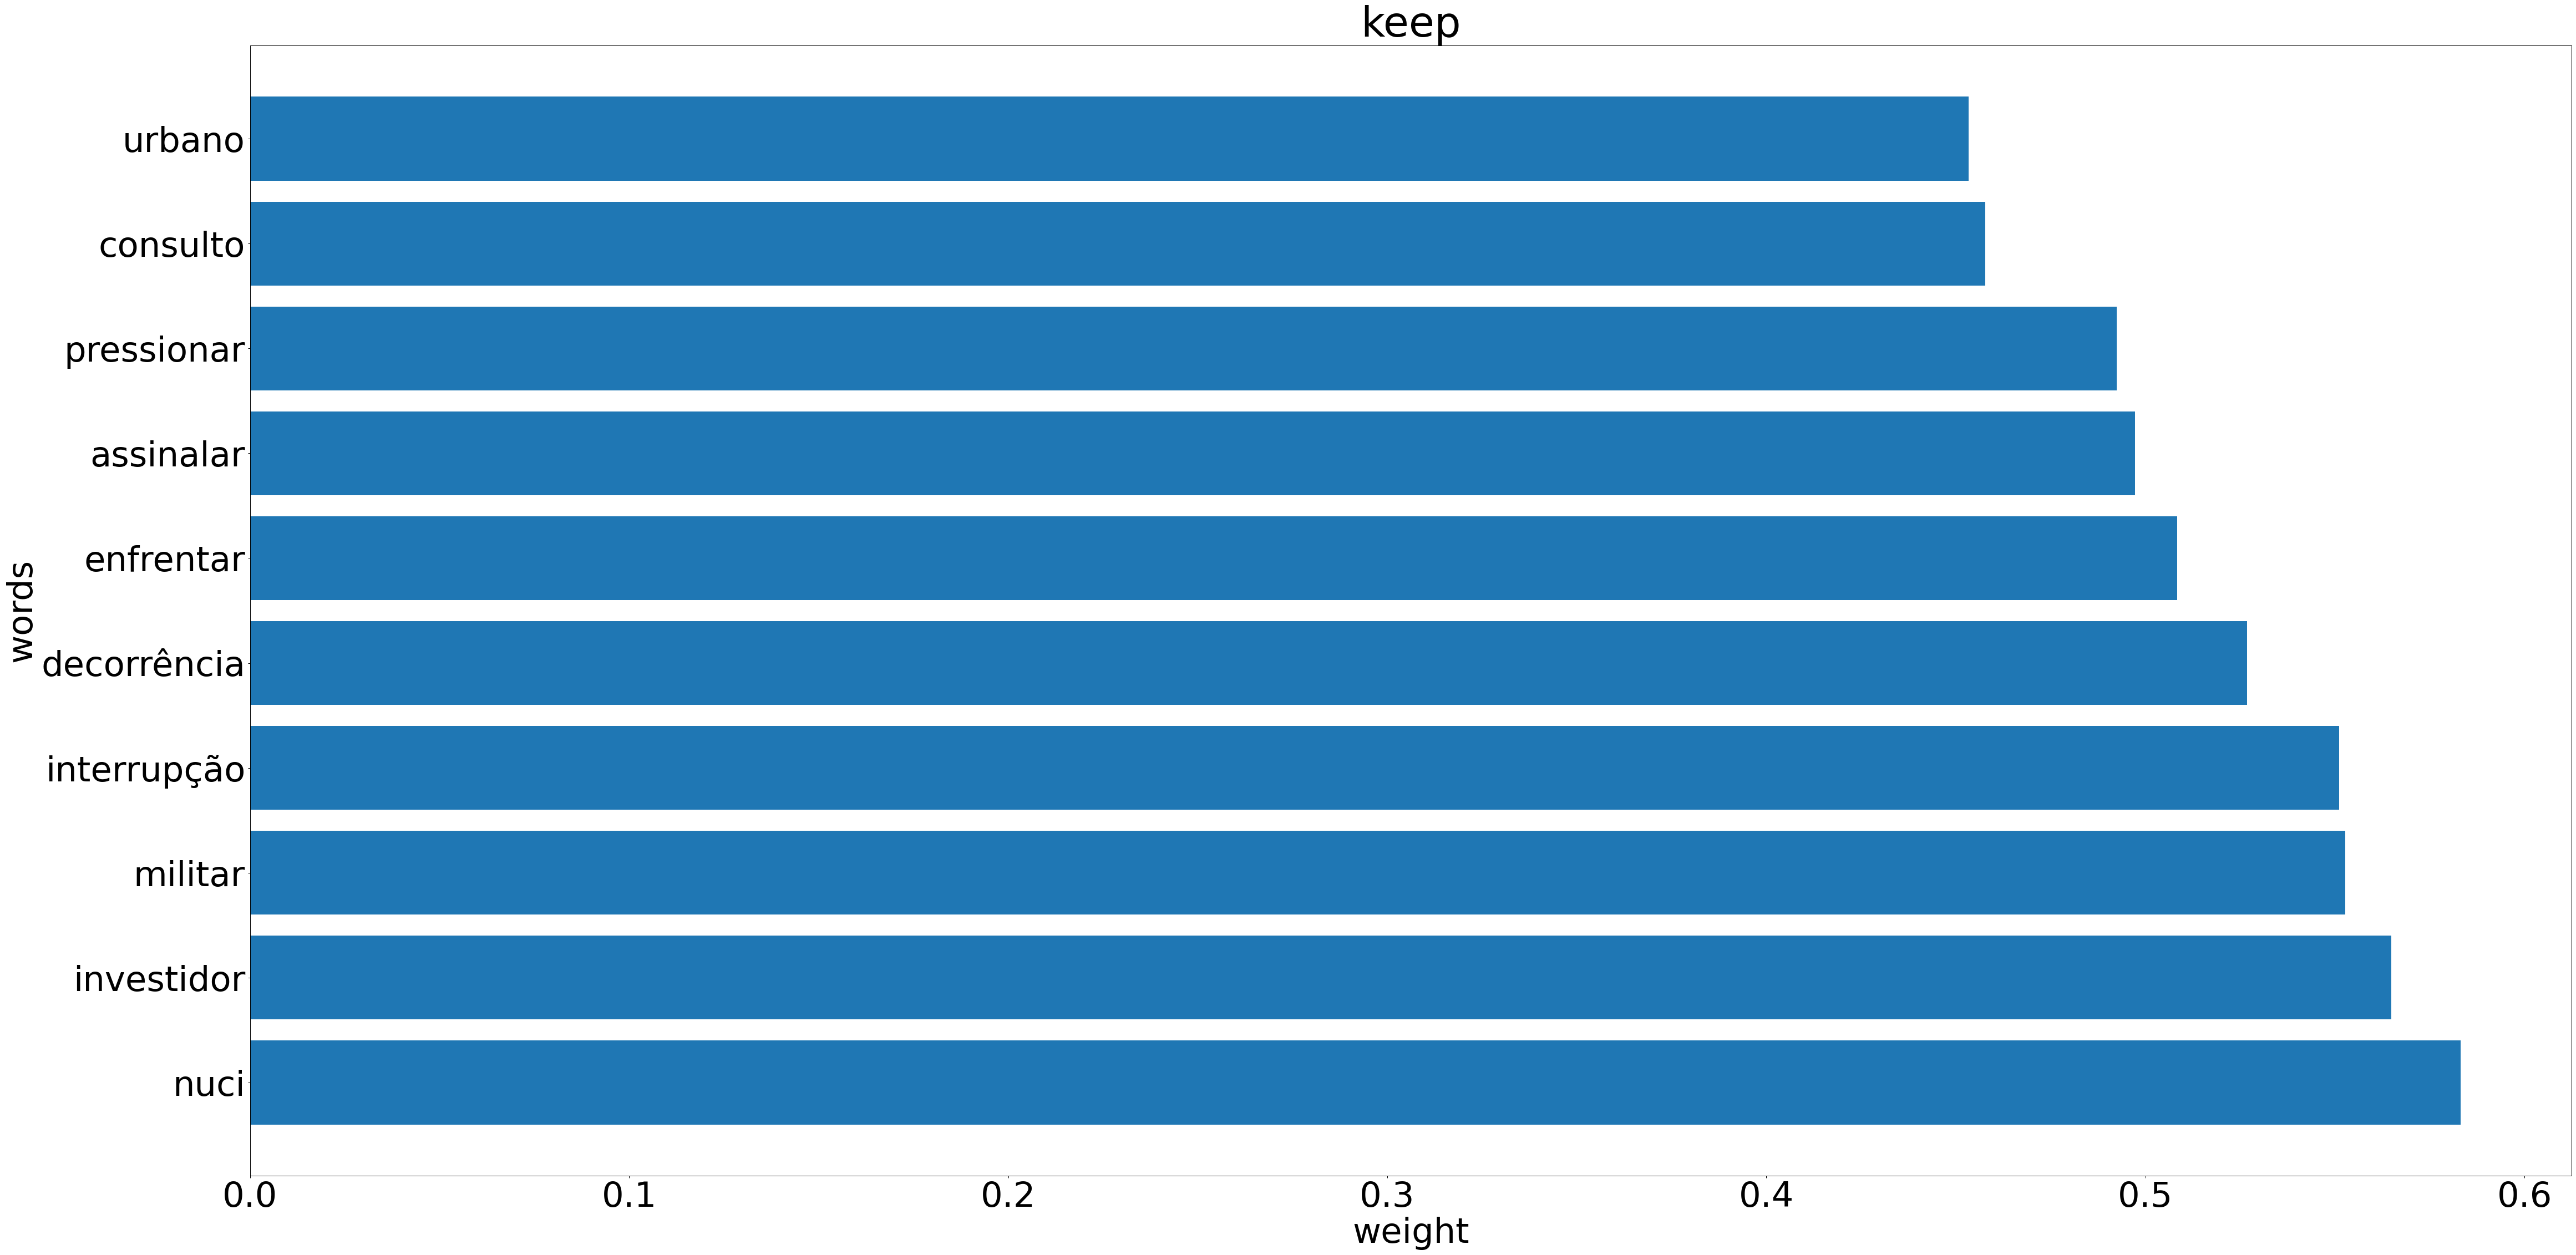

In [23]:
f_importances(SVMModel.coef_[0].todense().tolist()[0], list_words, 10, labels[0])

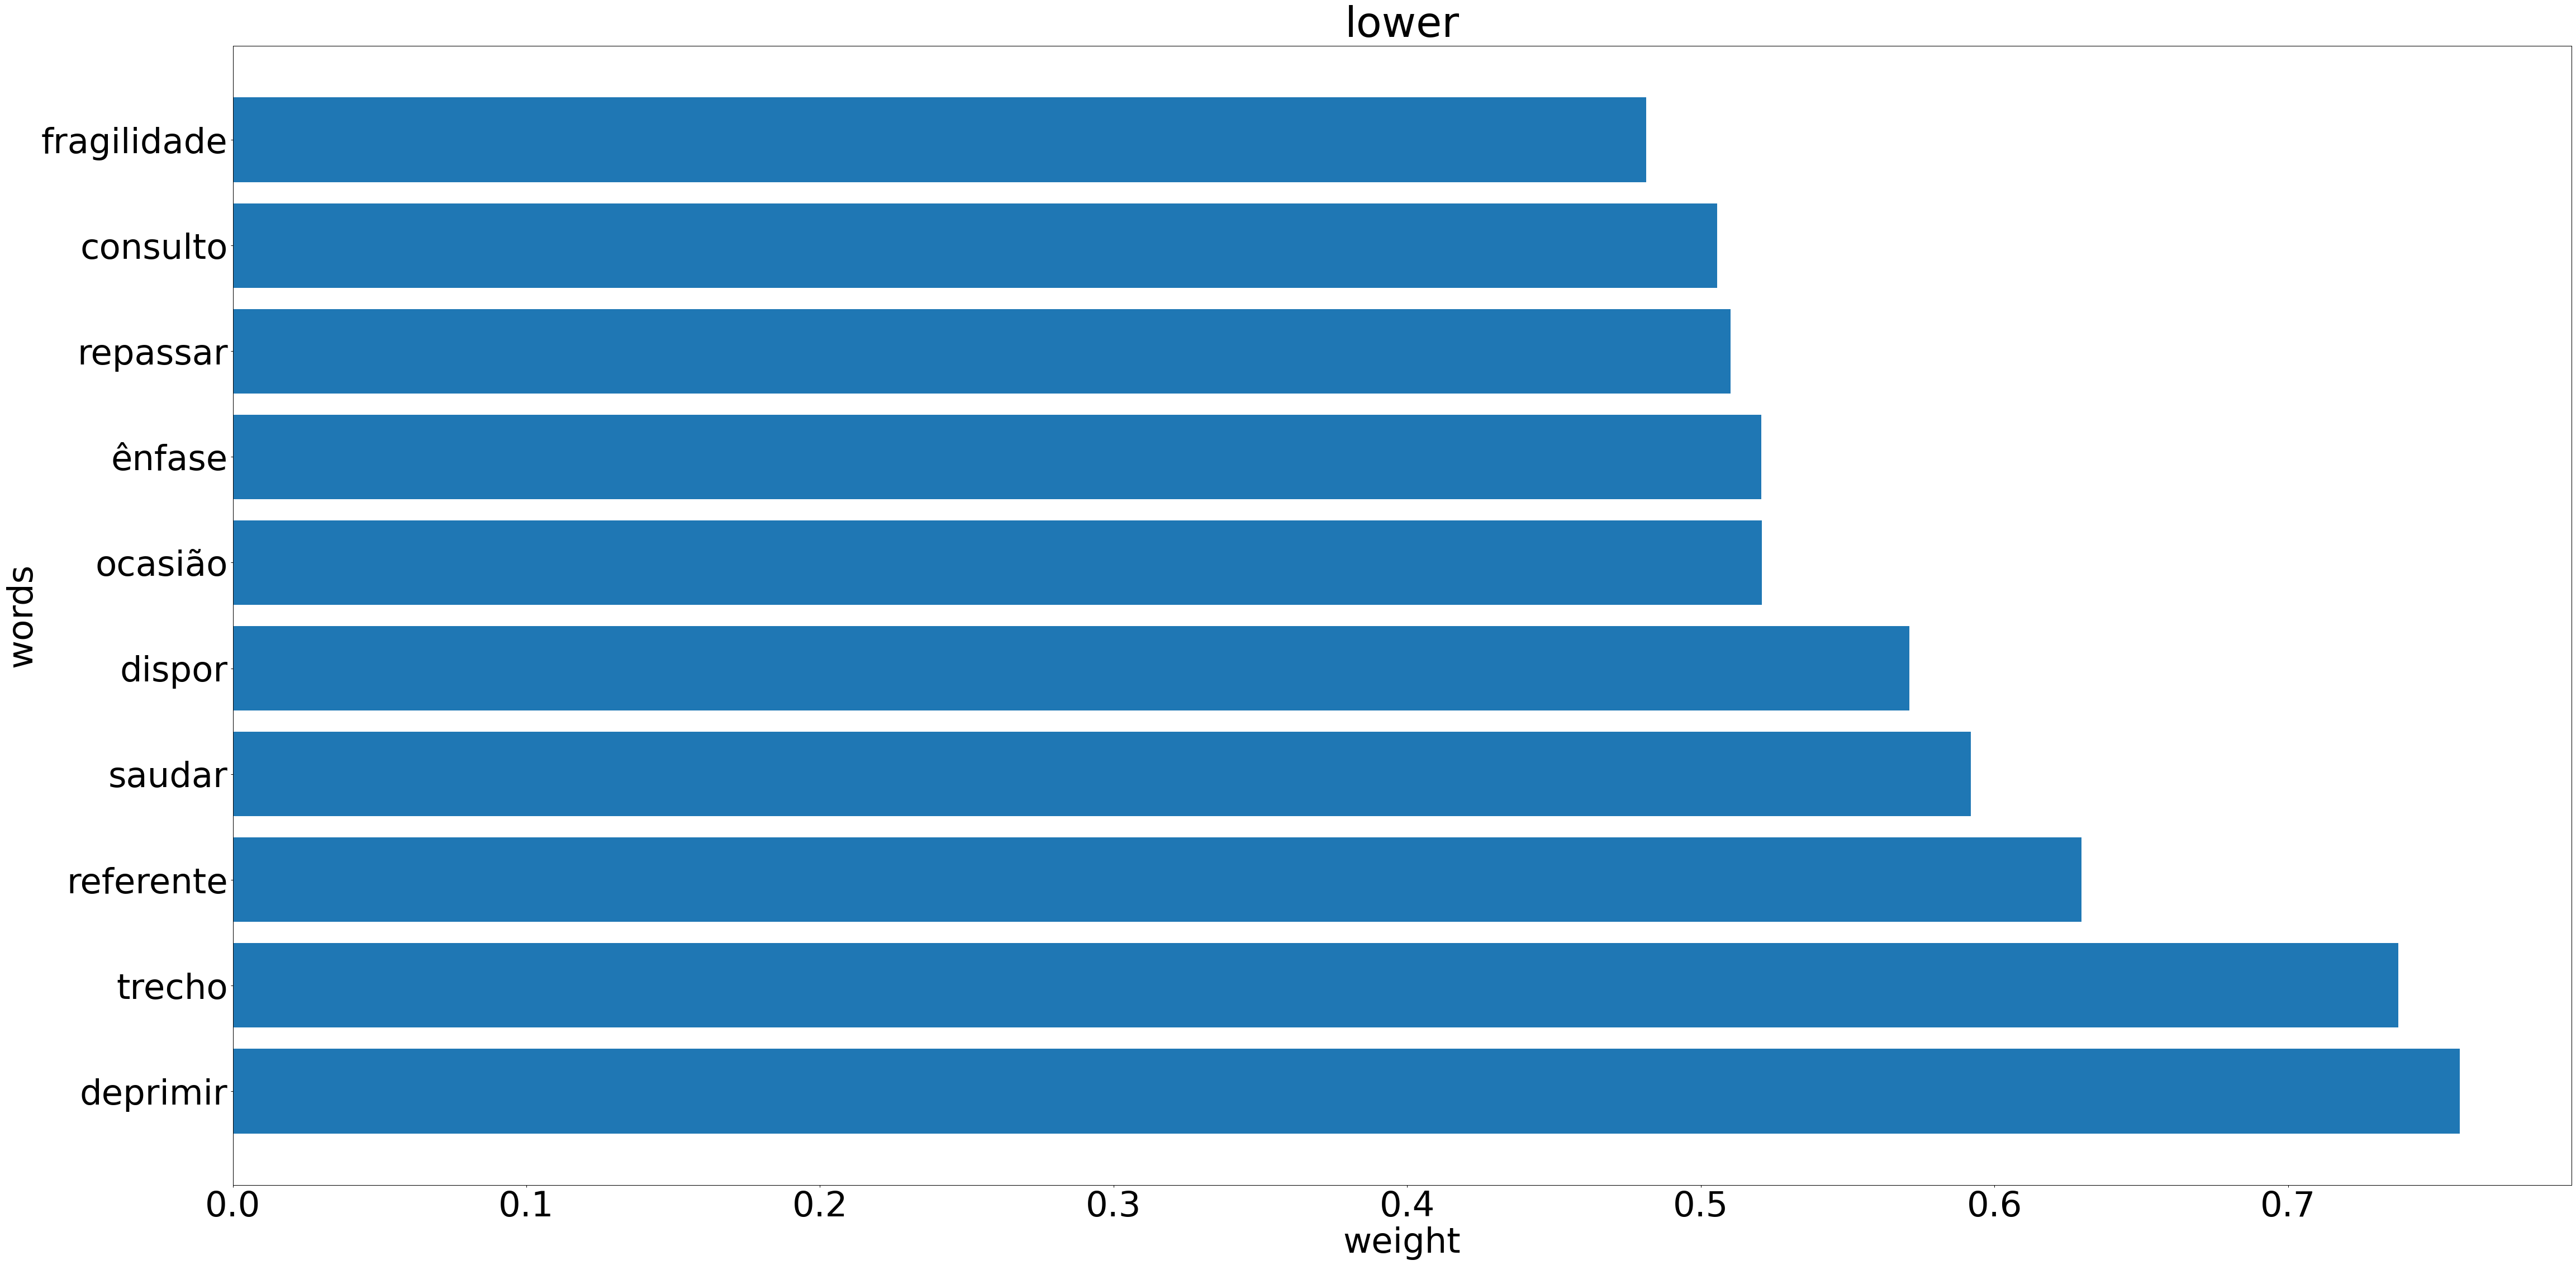

In [24]:
f_importances(SVMModel.coef_[1].todense().tolist()[0], list_words, 10, labels[1])

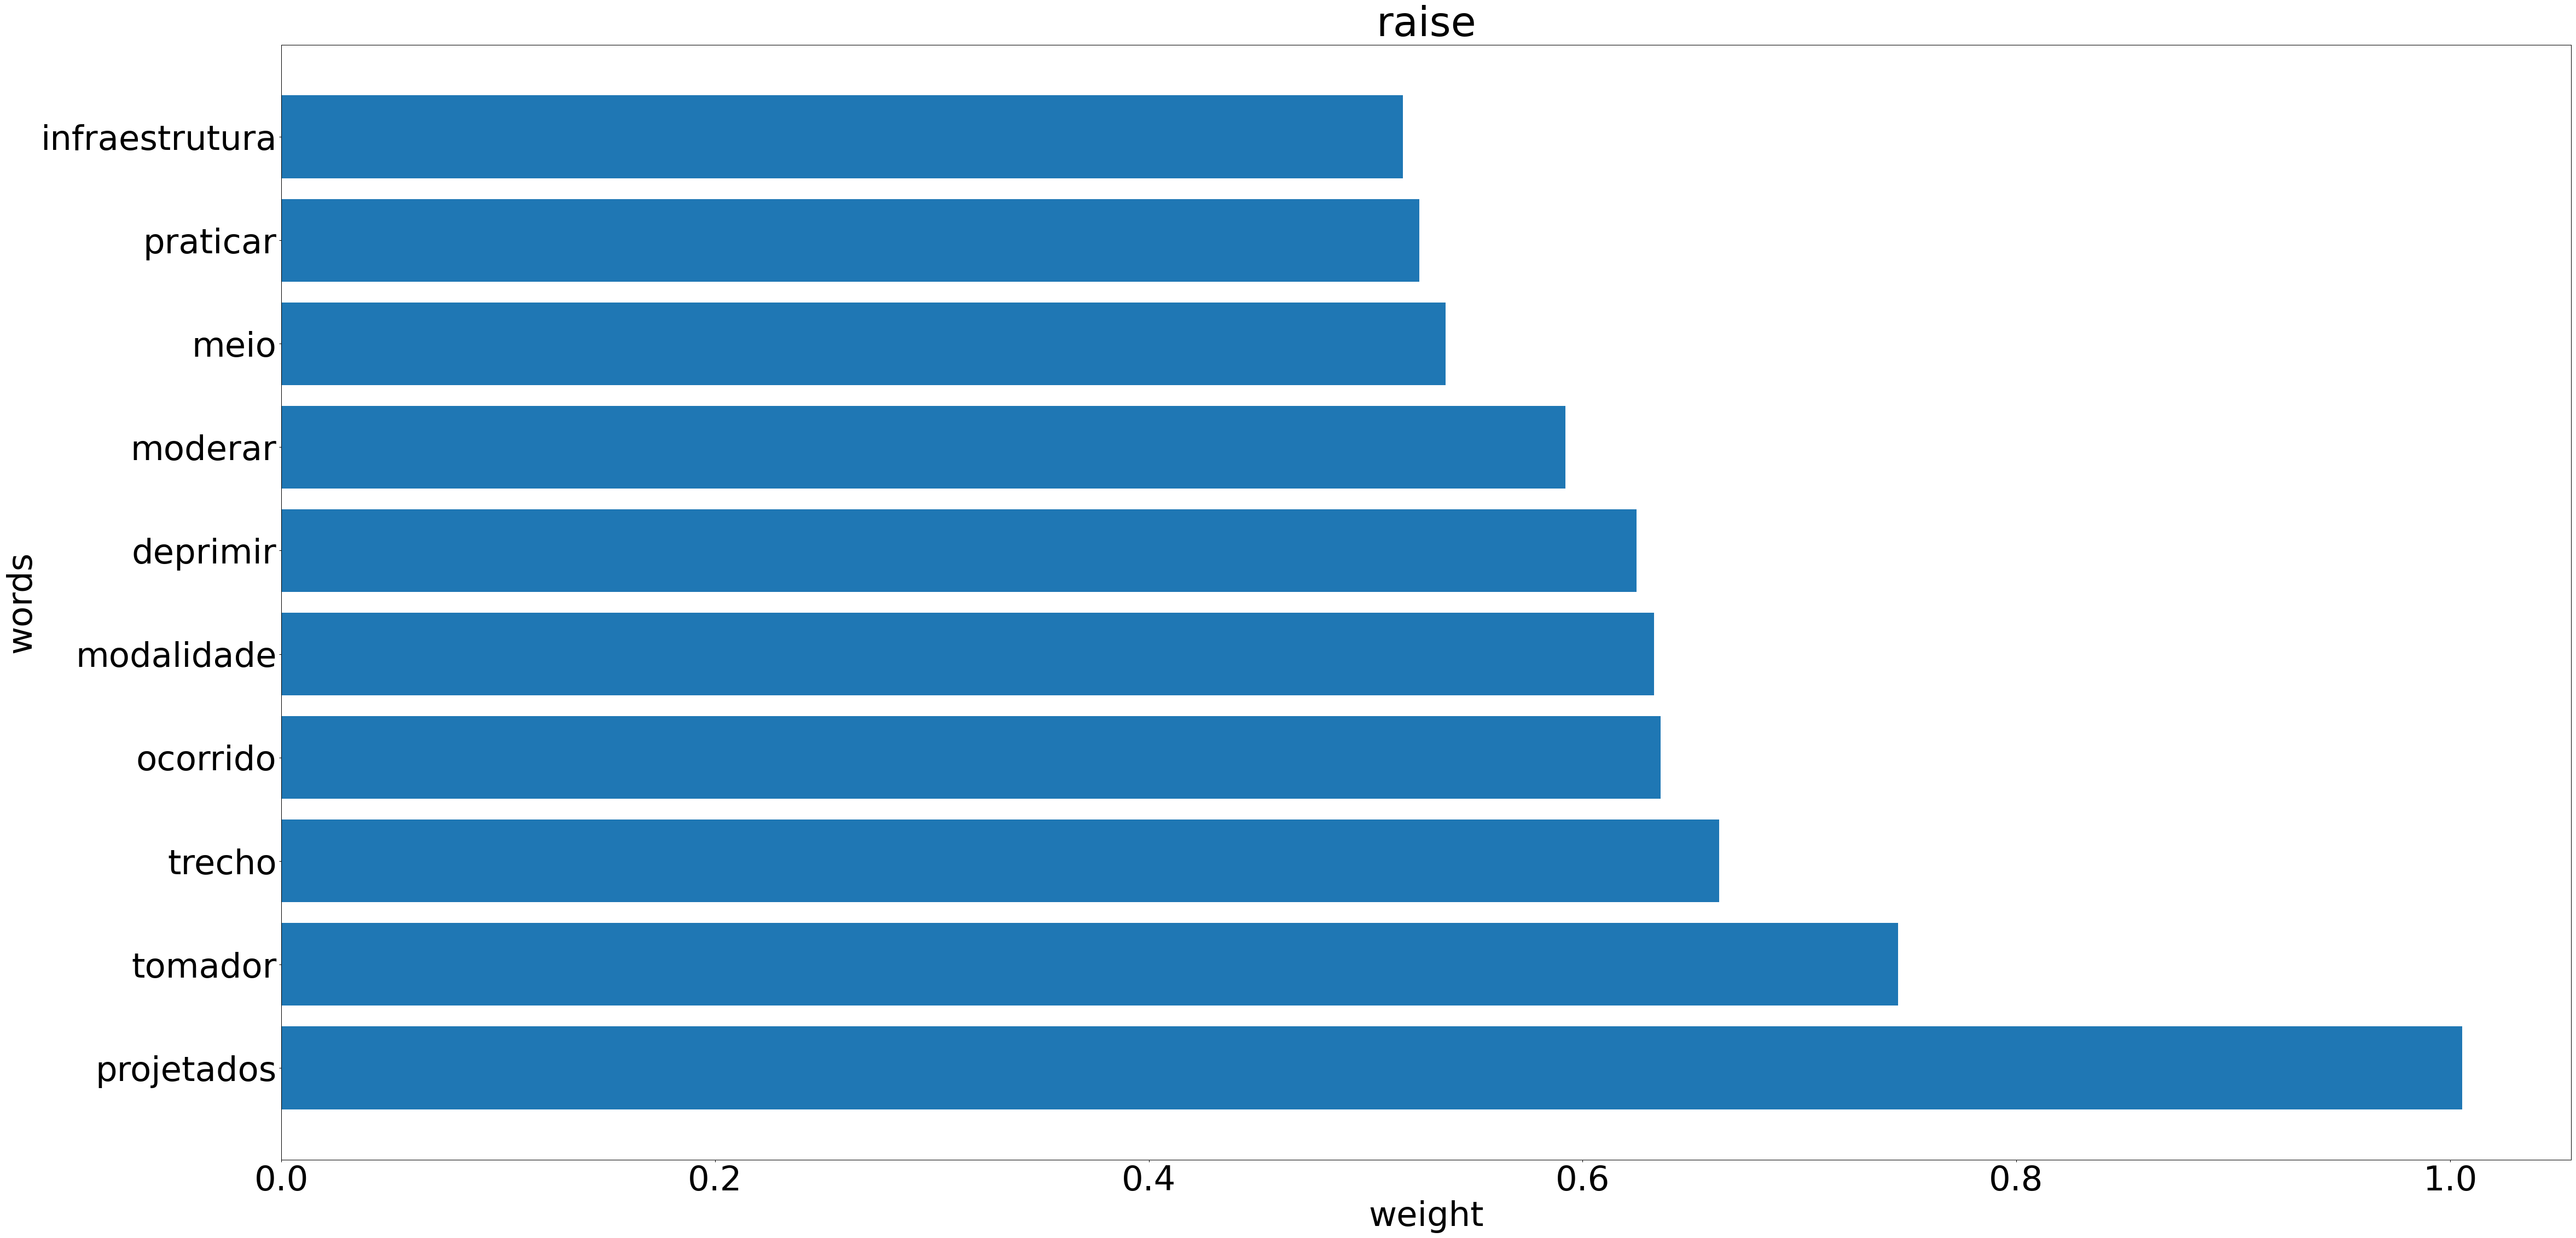

In [25]:
f_importances(SVMModel.coef_[2].todense().tolist()[0], list_words, 10, labels[2])

In [26]:
coefSVM = pd.DataFrame({'words': list_words,
                      'keep': np.reshape( SVMModel.coef_.todense().tolist()[0] , (SVMModel.coef_.shape[1],)),
                      'lower': np.reshape( SVMModel.coef_.todense().tolist()[1] , (SVMModel.coef_.shape[1],)),
                      'raise': np.reshape( SVMModel.coef_.todense().tolist()[2] , (SVMModel.coef_.shape[1],))})


In [27]:
for i in range(len(labels)):
    print("\n- Words correlated with: "+labels[i]+"\n\t", coefSVM.sort_values(by=labels[i], ascending=False).head(10).words.tolist())



- Words correlated with: keep
	 ['nuci', 'investidor', 'militar', 'interrupção', 'decorrência', 'enfrentar', 'assinalar', 'pressionar', 'consulto', 'urbano']

- Words correlated with: lower
	 ['deprimir', 'trecho', 'referente', 'saudar', 'dispor', 'ocasião', 'ênfase', 'repassar', 'consulto', 'fragilidade']

- Words correlated with: raise
	 ['projetados', 'tomador', 'trecho', 'ocorrido', 'modalidade', 'deprimir', 'moderar', 'meio', 'praticar', 'infraestrutura']


# Random Forest

In [28]:
#RANDOM FOREST
nome = "Random Forest"
RandomForestModel = ensemble.RandomForestClassifier(random_state=100)
parameters_ = {'n_estimators' : (50, 75, 100),
               'criterion': ('gini', 'entropy'),
               'max_depth':(20, 40, 50, None),
               'class_weight' : ('balanced','balanced_subsample',None)
               }

# TF IDF Vectors
print ("\n",nome," - TF-IDF VECTORS")
RandomForestModel = train_model(RandomForestModel, X_train_tfidf, y_train, X_test_tfidf, y_test, parameters = parameters_)



 Random Forest  - TF-IDF VECTORS
	class_weight: 'balanced_subsample'
	criterion: 'gini'
	max_depth: 20
	n_estimators: 75
       keep  lower  raise
keep     17      6      2
lower     6     19      0
raise     3      2     14


              precision    recall  f1-score   support

        keep       0.65      0.68      0.67        25
       lower       0.70      0.76      0.73        25
       raise       0.88      0.74      0.80        19

    accuracy                           0.72        69
   macro avg       0.74      0.73      0.73        69
weighted avg       0.73      0.72      0.73        69

Kappa score: 0.581

Accuracy score: 0.725

f1 weighted score: 0.727

Balanced Accuracy score: 0.726



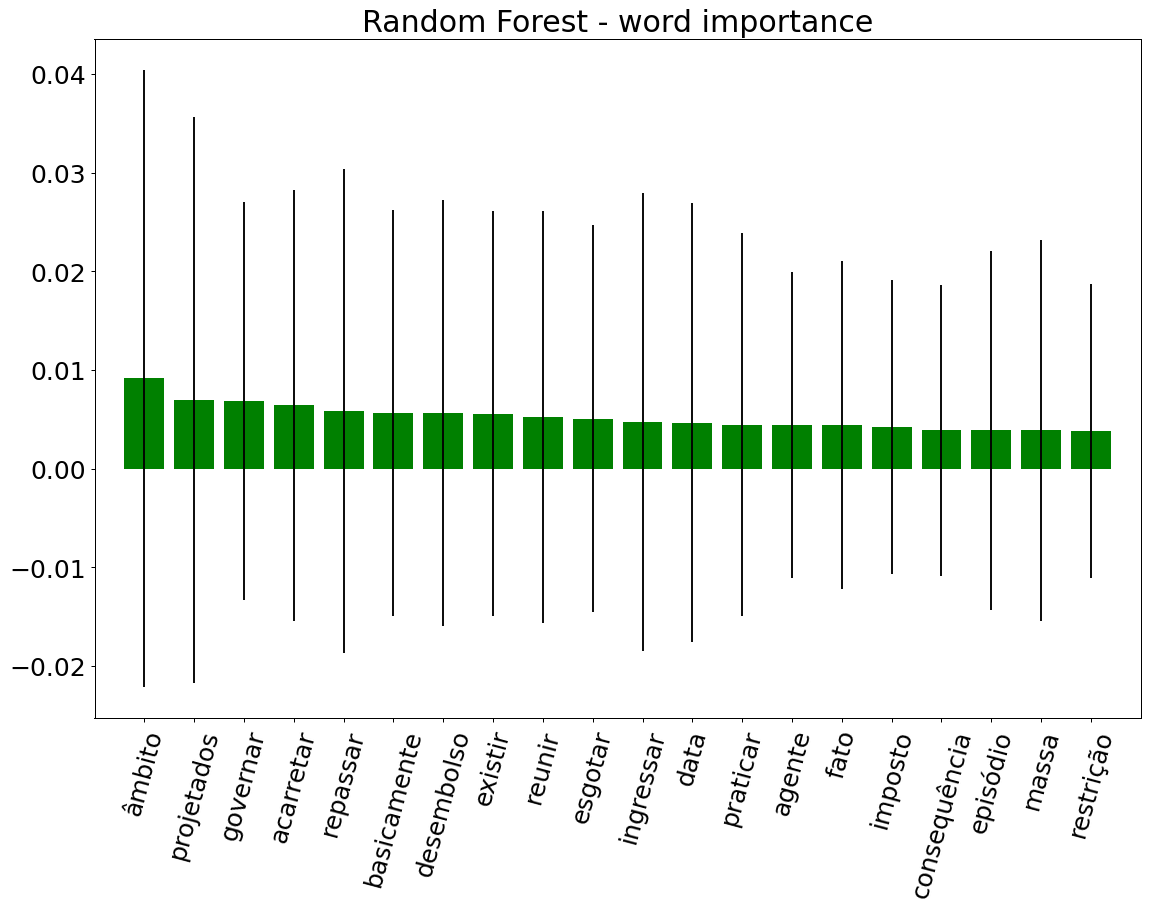

In [29]:
imp = pd.DataFrame(data=RandomForestModel.feature_importances_, index=list_words, columns=['importance'])
#imp.sort_values('importance', ascending=False)

std = np.std([tree.feature_importances_ for tree in RandomForestModel.estimators_],
             axis=0)

indices = np.argsort(RandomForestModel.feature_importances_)[::-1]

nr_words=20
indices = indices[:nr_words]

plt.rcParams.update({'font.size': 20})

plt.figure(figsize=(15,10));
plt.title("Random Forest - word importance")
plt.bar(range(nr_words), RandomForestModel.feature_importances_[indices],
        color="g", yerr=std[indices], align="center")
plt.xticks(range(nr_words), pd.Index(list_words)[indices], rotation=75)
plt.xlim([-1, nr_words])
plt.show();

In [30]:
eli5.show_weights(RandomForestModel, top=10, target_names=labels, feature_names=list_words)

Weight,Feature
0.0092 ± 0.0626,âmbito
0.0070 ± 0.0574,projetados
0.0068 ± 0.0403,governar
0.0065 ± 0.0437,acarretar
0.0059 ± 0.0491,repassar
0.0057 ± 0.0412,basicamente
0.0056 ± 0.0431,desembolso
0.0056 ± 0.0411,existir
0.0053 ± 0.0417,reunir
0.0051 ± 0.0393,esgotar


In [31]:
eli5.show_prediction(RandomForestModel, X_test[0][:1000], vec=tfidf_vect, target_names=labels, top=10)

/usr/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
